In [1]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import json
from Preference_Embeddings.JAXEmbeddings import ComplexPreference
from typing import Callable
import flax.serialization as serialization
from Stackelberg.src.utils.utility_functions import ackley, branin, eggholder, hoelder, matyas, michalewicz, rosenbrock, bukin
from collections import namedtuple
import os

In [2]:
def get_model(name: str) -> Callable:
    # -----------------------------------------------------------------------------
    # 2.2) Read hyperparameters from JSON
    # -----------------------------------------------------------------------------
    hparam_path = f"../Embedding_Model_Weights/{name}.json"
    with open(hparam_path, "r") as f:
        metadata = json.load(f)
    hparams = metadata["hparams"]
    in_dim = hparams["in_dim"]
    factor = hparams["factor"]
    sizes  = hparams["sizes"]  # e.g. [128, 64]

    # Re‐instantiate the Flax model with these hyperparameters
    model_def = ComplexPreference(in_dim=in_dim, factor=factor, sizes=sizes)

    # -----------------------------------------------------------------------------
    # 2.3) Build a dummy “params” PyTree to use as a template
    # -----------------------------------------------------------------------------
    # ANY batch_size ≥ 1 will do; we only need correct shapes.
    rng = jax.random.PRNGKey(0)
    dummy_x  = jnp.zeros((1, in_dim), dtype=jnp.float32)
    dummy_xp = jnp.zeros((1, in_dim), dtype=jnp.float32)

    variables    = model_def.init(rng, dummy_x, dummy_xp)
    dummy_params = variables["params"]  # a FrozenDict tree matching the saved structure

    # -----------------------------------------------------------------------------
    # 2.4) Read the saved parameter bytes and re‐hydrate them
    # -----------------------------------------------------------------------------
    param_path = f"../Embedding_Model_Weights/{name}.msgpack"
    with open(param_path, "rb") as f:
        loaded_bytes = f.read()

    restored_params = serialization.from_bytes(dummy_params, loaded_bytes)
    return lambda x, y: model_def.apply({"params": restored_params}, x, y)

In [3]:
AffineTransform = namedtuple("AffineTransform", ["affine_transform"])
affine_transform = AffineTransform(jnp.array([1.,0.]))
funcs = {
    "ackley": {
        "func": ackley,
        "bounds": [[-32.768, 32.768],]*2,
        "sizes": [512, 256, 128 ,64 ,32],
        "branches": 3
    },
    "branin": {
        "func": branin,
        "bounds": [[-5, 10], [0, 15]],
        "sizes": [256, 128 ,64]
    },
    "eggholder": {
        "func": eggholder,
        "bounds": [[-512,512],]*2,
        "sizes": [512, 256, 128 ,64, 32]
    },
    "hoelder":{
        "func": hoelder,
        "bounds": [[-10,10],]*2,
        "sizes": [512, 256, 128 ,64],
        "branches": 2
    },
    "matyas": {
        "func": matyas,
        "bounds": [[-10,10],]*2,
        "sizes": [256, 128 ,64]
    },
    "michalewicz": {
        "func": michalewicz,
        "bounds": [[0,jnp.pi],]*2,
        "sizes": [256, 128 ,64]
    },
    "rosenbrock": {
        "func": rosenbrock,
        "bounds": [[-5,10],]*2,
        "sizes": [256, 128 ,64]
    },
    "bukin": {
        "func": bukin,
        "bounds": [[-15, -5],[-3,3]],
        "sizes": [512, 256, 128, 64],
        "branches": 2
    }
}

In [4]:
def evaluate_function_vectorized(f, x_lims, y_lims, n):
    """
    Vectorized evaluation of f on all pairs of grid points using broadcasting.

    Parameters:
        f (callable): Function that takes two arrays of shape (...,2) and returns an array of broadcasts.
        x_lims (tuple): (x_start, x_end) for the x-coordinate grid.
        y_lims (tuple): (y_start, y_end) for the y-coordinate grid.
        n (int): Number of points per dimension in each linspace.

    Returns:
        np.ndarray: Square matrix of shape (n*n, n*n) containing evaluations.
    """
    # Create 1D coordinate grids
    x = jnp.linspace(x_lims[0], x_lims[1], n)
    y = jnp.linspace(y_lims[0], y_lims[1], n)

    # Generate all grid points (shape: n x n x 2)
    X, Y = jnp.meshgrid(x, y, indexing='ij')
    grid_points = jnp.stack([X, Y], axis=-1)
    B = n * n

    # Flatten grid to shape (B, 2) and expand dimensions for broadcasting
    p1 = grid_points.reshape(B, 1, 2)  # Shape: (B, 1, 2)
    p2 = grid_points.reshape(1, B, 2)  # Shape: (1, B, 2)

    # Evaluate f using broadcasting (f must support vectorized operations)
    return f(p1, p2)  # Result shape: (B, B)

def pairwise_evaluation(f, x_lims, y_lims):
    """
    Evaluate function f on all pairs of grid points using JAX vectorization.

    Args:
        f: Function (a, b) -> scalar where a, b are (2,)
        x_lims: x bounds
        y_lims: y bounds

    Returns:
        Matrix of shape (n_x*n_y, n_x*n_y) with f evaluated at all point pairs
    """
    # Create 2D grid of points
    # Create 1D coordinate grids
    x = jnp.linspace(x_lims[0], x_lims[1], n)
    y = jnp.linspace(y_lims[0], y_lims[1], n)
    X, Y = jnp.meshgrid(x, y, indexing='ij')
    points = jnp.stack([X, Y], axis=-1)  # Shape (n_x, n_y, 2)
    B = points.shape[0] * points.shape[1]

    # Flatten to (B, 2)
    points_flat = points.reshape(B, 2)

    # Vectorized evaluation using double vmap
    def f_wrapper(a, b):
        return f(a.reshape(2,), b.reshape(2,))

    # Vectorize over both arguments
    batched_f = jax.vmap(jax.vmap(f_wrapper, in_axes=(None, 0)), in_axes=(0, None))

    # Create all pairs
    result = batched_f(points_flat, points_flat)
    return result

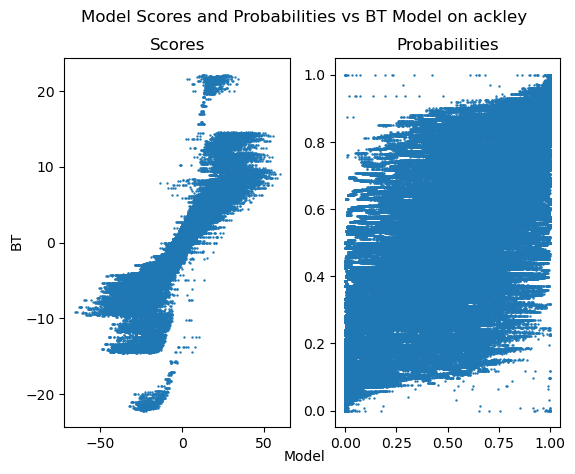

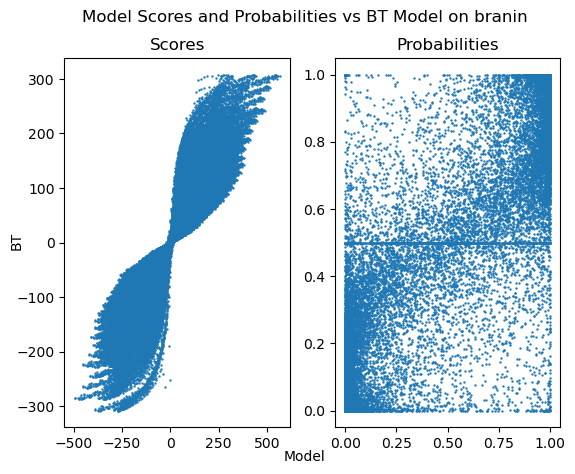

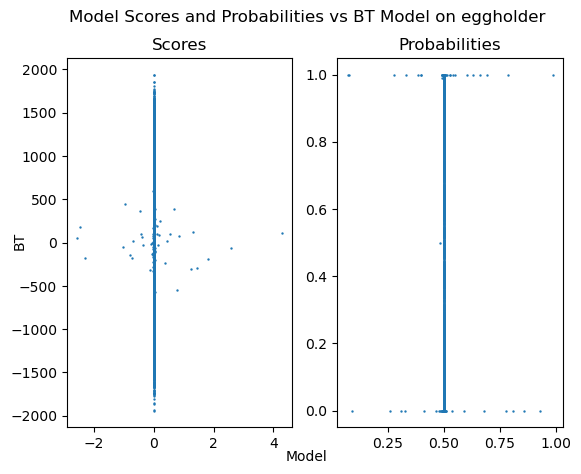

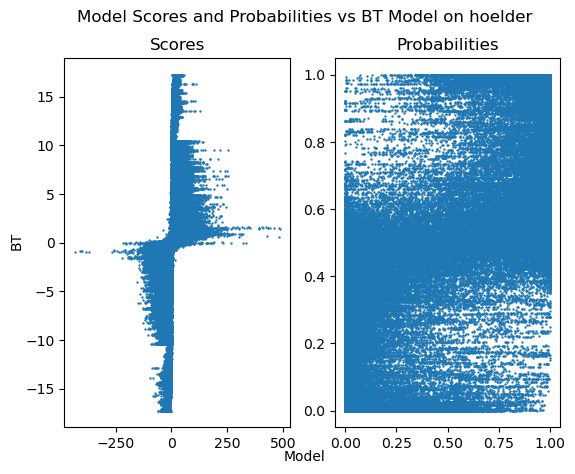

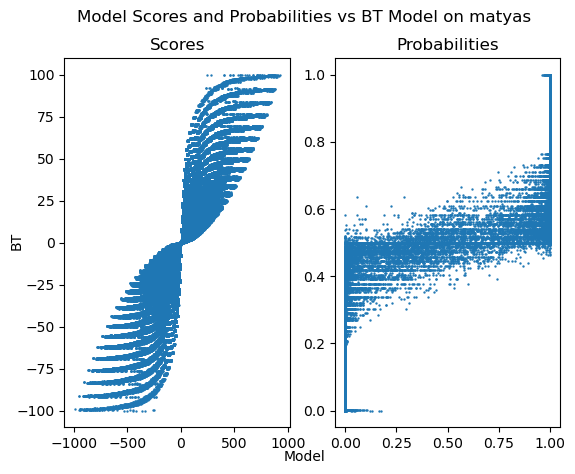

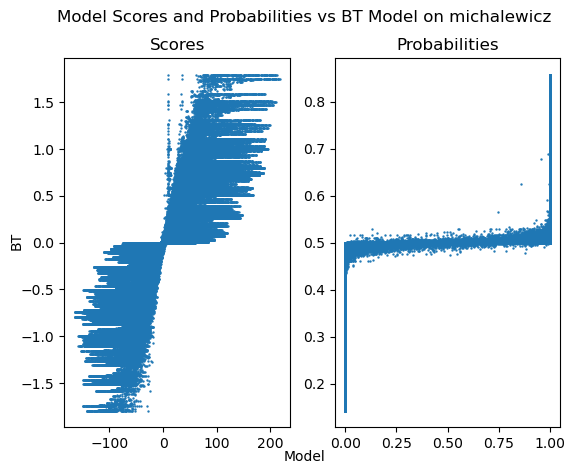

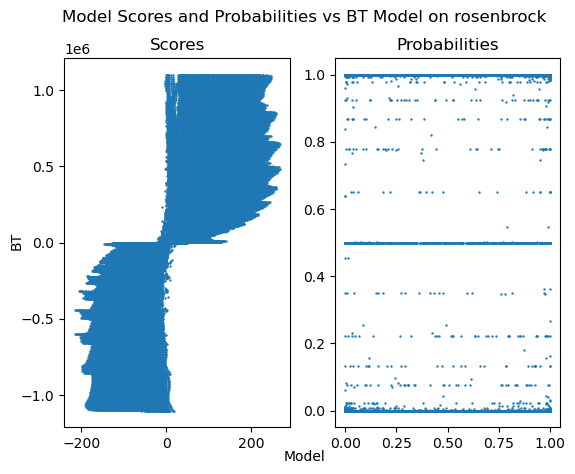

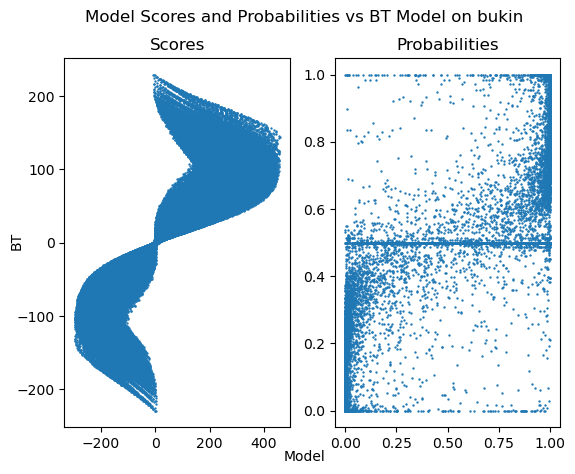

In [5]:
s = jax.nn.sigmoid
n=25
for func_name, func_data in funcs.items():
    model = get_model(func_name)
    func_raw = func_data["func"]
    func = lambda x: func_raw(x, params=affine_transform)
    bounds = func_data["bounds"]
    comparison_func = lambda x, y: func(x) - func(y)
    model_scores = evaluate_function_vectorized(model, bounds[0], bounds[1], n)
    bt_scores = pairwise_evaluation(comparison_func, bounds[0], bounds[1])
    fig, axs = plt.subplots(1, 2)
    axs[0].scatter(-model_scores.flatten(), bt_scores.flatten(), s=0.5, label="Scores")
    axs[0].set_title("Scores")
    axs[1].scatter(s(-model_scores.flatten()), s(bt_scores.flatten()),s=0.5, label="Probabilities")
    axs[1].set_title("Probabilities")
    fig.suptitle("Model Scores and Probabilities vs BT Model on " + func_name)
    fig.text(0.5, 0.04, 'Model', ha='center')
    fig.text(0.04, 0.5, 'BT', va='center', rotation='vertical')
    plt.show()